In [7]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SIR_sto_traj.npy', data_array)

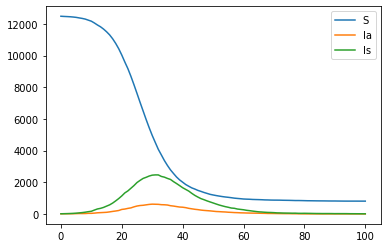

In [4]:
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='Ia')
plt.plot(data_array[:, 2*M], label='Is')
plt.legend()
plt.show()

In [5]:
# load the data and rescale to intensive variables 
Tf = 50 # truncate to only getting the first few datapoints 
Nf = Tf+1

x = np.load('SIR_sto_traj.npy').astype('float')
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-764.2260536397586
0.3199739456176758


In [7]:
# take a guess 
beta_g = 0.2
gIa_g = 0.01
gIs_g = 0.01
alpha_g = 0.1
guess = [alpha_g, beta_g, gIa_g, gIs_g]

# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp) 

344945.4372370481


In [8]:
# inference 

eps = 1e-4 
bounds = [(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6)] # give some bounds
start_time = time.time() 
params, nit = estimator.inference(guess, x, Tf, Nf, contactMatrix, 
                                  niter=1, method='L-BFGS-B', bounds=bounds, 
                                  eps=eps, verbose=True)
# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params) # best guess 
print(nit) # number of iterations of the optimization run 
print(end_time - start_time)

[0.1  0.2  0.01 0.01] 344945.4372370481
[0.1001 0.2    0.01   0.01  ] 344951.3243796697
[0.1    0.2001 0.01   0.01  ] 345310.8983499796
[0.1    0.2    0.0101 0.01  ] 344754.31482102076
[0.1    0.2    0.01   0.0101] 343954.6503971669
[1.e-04 1.e-04 6.e-01 6.e-01] 4892790.7031843485
[2.e-04 1.e-04 6.e-01 6.e-01] 4892788.574531699
[1.e-04 2.e-04 6.e-01 6.e-01] 2448838.801917852
[1.000e-04 1.000e-04 6.001e-01 6.000e-01] 4892846.272582464
[1.000e-04 1.000e-04 6.000e-01 6.001e-01] 4892970.582547791
[0.05103555 0.10202209 0.29917944 0.29917944] 60185.84471779877
[0.05113555 0.10202209 0.29917944 0.29917944] 60182.372161138606
[0.05103555 0.10212209 0.29917944 0.29917944] 60261.085291468844
[0.05103555 0.10202209 0.29927944 0.29917944] 60187.91058616018
[0.05103555 0.10202209 0.29917944 0.29927944] 60190.17337215816
[0.05158985 0.0769017  0.3014209  0.29680225] 42257.01108279522
[0.05168985 0.0769017  0.3014209  0.29680225] 42253.51354972431
[0.05158985 0.0770017  0.3014209  0.29680225] 42324.

[0.1841105  0.01999852 0.13099124 0.14591038] -763.0544010882314
[0.1840105  0.02009852 0.13099124 0.14591038] -763.0414979809674
[0.1840105  0.01999852 0.13109124 0.14591038] -763.0442542495731
[0.1840105  0.01999852 0.13099124 0.14601038] -763.0336974802746
[0.18381098 0.0200221  0.13132394 0.14596678] -763.0926959094558
[0.18391098 0.0200221  0.13132394 0.14596678] -763.1208306903969
[0.18381098 0.0201221  0.13132394 0.14596678] -762.8904352769664
[0.18381098 0.0200221  0.13142394 0.14596678] -763.0948226054875
[0.18381098 0.0200221  0.13132394 0.14606678] -763.0858721115034
basinhopping step 0: f -763.093
[0.23743021 0.0961198  0.03893507 0.05052626] 63418.623549885415
[0.23753021 0.0961198  0.03893507 0.05052626] 63418.757450645455
[0.23743021 0.0962198  0.03893507 0.05052626] 63500.25102994177
[0.23743021 0.0961198  0.03903507 0.05052626] 63405.34423834759
[0.23743021 0.0961198  0.03893507 0.05062626] 63370.12228500641
[1.e-04 1.e-04 6.e-01 6.e-01] 4892790.7031843485
[2.e-04 1.e-

[0.19563917 0.02010182 0.14007576 0.14370714] -764.6131955765185
[0.19563917 0.02000182 0.14017576 0.14370714] -764.6474372298218
[0.19563917 0.02000182 0.14007576 0.14380714] -764.6524325845724
[0.19563917 0.02000182 0.14007576 0.14370714] -764.647074854749
[0.19573917 0.02000182 0.14007576 0.14370714] -764.6444689835015
[0.19563917 0.02010182 0.14007576 0.14370714] -764.6131955589125
[0.19563917 0.02000182 0.14017576 0.14370714] -764.6474372530153
[0.19563917 0.02000182 0.14007576 0.14380714] -764.6524325349541
[0.19563917 0.02000182 0.14007576 0.14370714] -764.6470749611992
[0.19573917 0.02000182 0.14007576 0.14370714] -764.6444690046715
[0.19563917 0.02010182 0.14007576 0.14370714] -764.6131955765185
[0.19563917 0.02000182 0.14017576 0.14370714] -764.6474372298218
[0.19563917 0.02000182 0.14007576 0.14380714] -764.6524325845724
[0.19563917 0.02000182 0.14007576 0.14370714] -764.6470749611992
[0.19573917 0.02000182 0.14007576 0.14370714] -764.6444690046715
[0.19563917 0.02010182 0.1

In [9]:
# compute log_p for best estimate 
start_time = time.time() 
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-764.6470749793613
0.33295202255249023
